# Energy VS Volume Analysis

In [1]:
%%bash
# Get results
# git submodule update --remote
# git pull

In [2]:
import copy
import json
%load_ext autoreload
from pathlib import Path
# Get submodule directory
RESULTS_ROOT = Path.cwd().parent.absolute() / 'tb_results'
RESULTS_ROOT

PosixPath('/Users/alexanderbuccheri/Codes/tb_benchmarking/tb_results')

In [13]:
"""E vs V Functions
"""
import numpy as np
from typing import Union

from delta_factor.fit_eos import fit_birch_murnaghan_relation, parse_birch_murnaghan_relation, EVCurveData, calculate_birch_murnaghan_relation


def e_vs_v(result: Union[np.ndarray, EVCurveData]) -> dict:
    """ High-level processing of E vs V data.

    :param result: E vs V calculation result.
    :return processed_data: Data and corresponding model fit.
    """
    if isinstance(result, EVCurveData):
        vol, energy = result.volume, result.energy
    else:
        vol, energy = result[:, 0], result[:, 1]

    # Birch Murnaghan Fitting
    try:
        fit_data: dict = fit_birch_murnaghan_relation(vol, energy)
        equilibrium_energy = fit_data['ground_state_energy']['value']
        energy_model = parse_birch_murnaghan_relation(fit_data)
        linearly_sampled_volume = np.linspace(vol[0], vol[-1], 100)
        energy_fit = energy_model(linearly_sampled_volume)

        min_energy = np.amin(energy_fit)
        if np.abs((equilibrium_energy - min_energy) / min_energy) > 0.01:
            # If the equilibrium_energy value is not good, use the minimum value from the
            # model evaluated for the dense range of volumes
            equilibrium_energy = min_energy

    # If the fitting fails, fit with a polynomial and return the min volume/energy from discrete points
    # Note, this should only occur if a) the calculation is garbage or b) the input structure is
    # far from equilibrium
    except RuntimeError:
        print('BM Eq fit failed. Falling back to polynomial fit and discrete min energy/volume')
        coefficients = np.polyfit(vol, energy, 3)
        linearly_sampled_volume = np.linspace(vol[0], vol[-1], 100)
        energy_fit = np.polyval(coefficients, linearly_sampled_volume)
        equilibrium_energy = np.amin(energy)

    processed_data = {'model': {'volume': linearly_sampled_volume, 'energy': energy_fit - equilibrium_energy},
                  'data' : {'volume': vol, 'energy': energy - equilibrium_energy}
                    }

    return processed_data


def set_plot_range(model: dict, x_range: float, head_room=2) -> tuple:
    """Set plot range (x and y) for E vs V curves, according to
    the range of energy over which the delta factor was determined.
    """
    # X range
    # Limits consistent with the range over which delta factor was computed
    i_energy_min = np.argmin(model['energy'])
    v_eq = model['volume'][i_energy_min]
    xi = np.around(v_eq - x_range * v_eq, decimals=0)
    xf =  np.around(v_eq + x_range * v_eq, decimals=0)

    # Upper Y limit set according to x-range
    # Find max y in the x-range [xi:xf]
    index_xi = (np.abs(model['volume'] - xi)).argmin()
    index_xf = (np.abs(model['volume'] - xf)).argmin()
    energy_max = np.max(model['energy'][index_xi:index_xf])

    return (xi, xf), (0, head_room * energy_max)



In [14]:
""" Labelling and Key-map
"""
label_to_title = {'ws2': '$\mathregular{WS_2}$',
                  'mos2': '$\mathregular{MoS_2}$',
                  'gan': '$\mathregular{GaN}$',
                  'tio2_rutile': '$\mathregular{TiO_2}$ (rutile)',
                  'graphite': 'Graphite',
                  'tio2_ana': '$\mathregular{TiO_2}$ (anatase)',
                  'diamond': 'Diamond',
                  'pbs': '$\mathregular{PbS}$',
                  'ge': '$\mathregular{Ge}$',
                  'nacl': '$\mathregular{NaCl}$',
                  'zno': '$\mathregular{ZnO}$',
                  'gaas': '$\mathregular{GaAs}$',
                  'mgo': '$\mathregular{MgO}$',
                  'si': '$\mathregular{Si}$',
                  'cdse': '$\mathregular{CdSe}$',
                  'bn_hex': '$\mathregular{BN}$ (hexagonal)',
                  'bn_cubic': '$\mathregular{BN}$ (cubic)',
                  'zro2': '$\mathregular{ZrO_2}$',
                  'wo3_monoclinic': '$\mathregular{WO_3}$'
                  }

# Map E vs V file name to the internal material labelling we use....
# Because the file names don't all match the materials labels we use internally
output_to_internal_label = {'bn_cubic': 'bn_cubic', 'bn_hex': 'bn_hex', 'cdse': 'cdse', 'diamond': 'diamond', 'gaas': 'gaas', 'gan': 'gan',
                            'ge': 'germanium', 'graphite': 'graphite', 'mgo': 'mgo', 'mos2': 'mos2', 'nacl': 'nacl', 'pbs': 'pbs',
                            'si': 'silicon', 'tio2_ana': 'tio2_ana', 'tio2_rutile': 'tio2_rutile', 'ws2': 'ws2',
                            'zno': 'zinc_oxide', 'zro2': 'zro2', 'wo3_monoclinic': 'wo3_monoclinic'}

In [15]:
%autoreload
"""E vs V Comparison for a tight-binding code and QE
"""
import itertools
import math
import matplotlib.pyplot as plt
from typing import List

from delta_factor.loader import tblite_loader, qe_loader
from tb_lite.crystal_references.crystal_systems import bulk_materials


def binned_plot_e_vs_v(materials: List[str], results: dict, bin_size=2, vol_range=None):
    """ Plot E vs V. TBLite vs Espresso. Full range

    Generalised to take N results.
    """
    binned_materials = bin_list(materials, bin_size)

    for bin in binned_materials:
        fig, axs = plt.subplots(1, bin_size, figsize=(16,4))

        for i, material in enumerate(bin):
            print(material)
            for result in results:
                data = e_vs_v(result[material])

                axs[i].set_xlabel(r"Volume ($\AA^3$)")
                axs[i].set_ylabel("Cell Energy (eV)")

                axs[i].plot(data['model']['volume'], data['model']['energy'], '-', color=result['color'])
                axs[i].plot(data['data']['volume'],  data['data']['energy'],  'o', color=result['color'], label=result['label'])

            if vol_range is not None:
                x_lim, y_lim = set_plot_range(data['model'], vol_range, head_room=2)
                axs[i].set_xlim(x_lim)

            axs[i].legend()
            axs[i].set_title(label_to_title[material])

    return fig, axs


def plot_e_vs_v(system_names, datas: List[dict], n_cols=4, vol_range = np.infty, y_limit = None):
    """ Publication-quality E vs V plot, with range and columns defined as input args.

    """
    # Plot settings
    n_rows = math.ceil(len(system_names) / n_cols)
    assert n_rows > 0, "Must have at least one row"

    # Calculate the aspect ratio of standard A4
    aspect_ratio = 297.0 / 210.0

    # Calculate the width of the figure in inches
    fig_width = 8.3  # A4 width in inches (approx)

    # Calculate the height of the figure in inches to maintain aspect ratio
    fig_height = fig_width / aspect_ratio * (n_rows / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
    #fig.tight_layout(h_pad=2.5)
    # Let matplotlib decide on the tight layout - better results
    fig.set_tight_layout(True)
    
    # ± limits for x-axis. Note, delta factor computed for ±0.06 V_eq
    set_range = vol_range != np.infty
    if set_range:
        print(f'Setting x range to ± {1-vol_range} V_eq')

    # Point and line sizes
    # All originally hard-coded for 2 columns per row, so scale appropriately
    scale = 2. / n_cols
    line_width = int(2 * scale)
    marker_size = int(7 * scale)
    label_size = int(18 * scale)     # 14
    font_size = int(18 * scale)      # 14
    leg_font_size = int(18 * scale)  # 14

    # Initialise counters
    empty_lims = 0, 0
    isys = -1

    # Plot
    for i, j in itertools.product(range(n_rows), range(n_cols)):
        isys += 1

        # Exit when last entry is reached.
        if isys > len(system_names) - 1:
            empty_lims = i, j
            break

        system = system_names[isys]
        atoms = bulk_materials[output_to_internal_label[system]]
        # eV / n-atoms
        prefactor = 1 / float(len(atoms.get_atomic_numbers()))

        # Process and plot data
        limits = {'x_min': 1000, 'x_max': -1000, 'y_min': 1000, 'y_max': -1000}

        for data in datas:
            ev_data = e_vs_v(data[system])
            # Scale energies appropriately
            ev_data['model']['energy'] *= prefactor
            ev_data['data']['energy'] *= prefactor

            axs[i, j].plot(ev_data['model']['volume'], ev_data['model']['energy'], '-', color=data['color'], linewidth=line_width)
            axs[i, j].plot(ev_data['data']['volume'],  ev_data['data']['energy'],  'o', color=data['color'], label=data['label'],  markersize=marker_size)

        # Set x and y limits
        if set_range:
            # Collect min and max limits according to the latest data
            # For volume range, this should be fine (put QE last in any list)
            x_lims, y_lims = set_plot_range(ev_data['model'], vol_range, head_room=2)
            axs[i, j].set_xlim(x_lims)
            #axs[i, j].set_ylim(top =y_lims[1])

        # If y_limit is passed, this takes priority
        if y_limit is not None:
            axs[i, j].set_ylim(y_limit)

        # Ticks
        axs[i, j].tick_params(axis='both', which='major', labelsize=label_size)
        axs[i, j].tick_params(axis='both', which='minor', labelsize=label_size)

        # Labels
        axs[i, j].set_xlabel(r"Volume ($\AA^3$)", fontsize=font_size)
        # "$\Delta E_{total}$ (meV / atom)"
        axs[i, j].set_ylabel("$E_{total}$ (eV / atom)", fontsize=font_size)
        # Disable for space-saving
        # axs[i, j].legend(prop={'size': leg_font_size})
        axs[i, j].set_title(label_to_title[system], fontsize=font_size)


    # # Remove any empty subplots
    if empty_lims != (0, 0):
        for i, j in itertools.product(range(empty_lims[0], n_rows), range(empty_lims[1], n_cols)):
            axs[i, j].remove()

    return fig, axs


E vs V: TBLite, QCore and QE
Note: TiO2 Anatase seems to be along way from equilibrum= =>
Should replace the CIF reference.
BM Eq fit failed. Falling back to polynomial fit and discrete min energy/volume


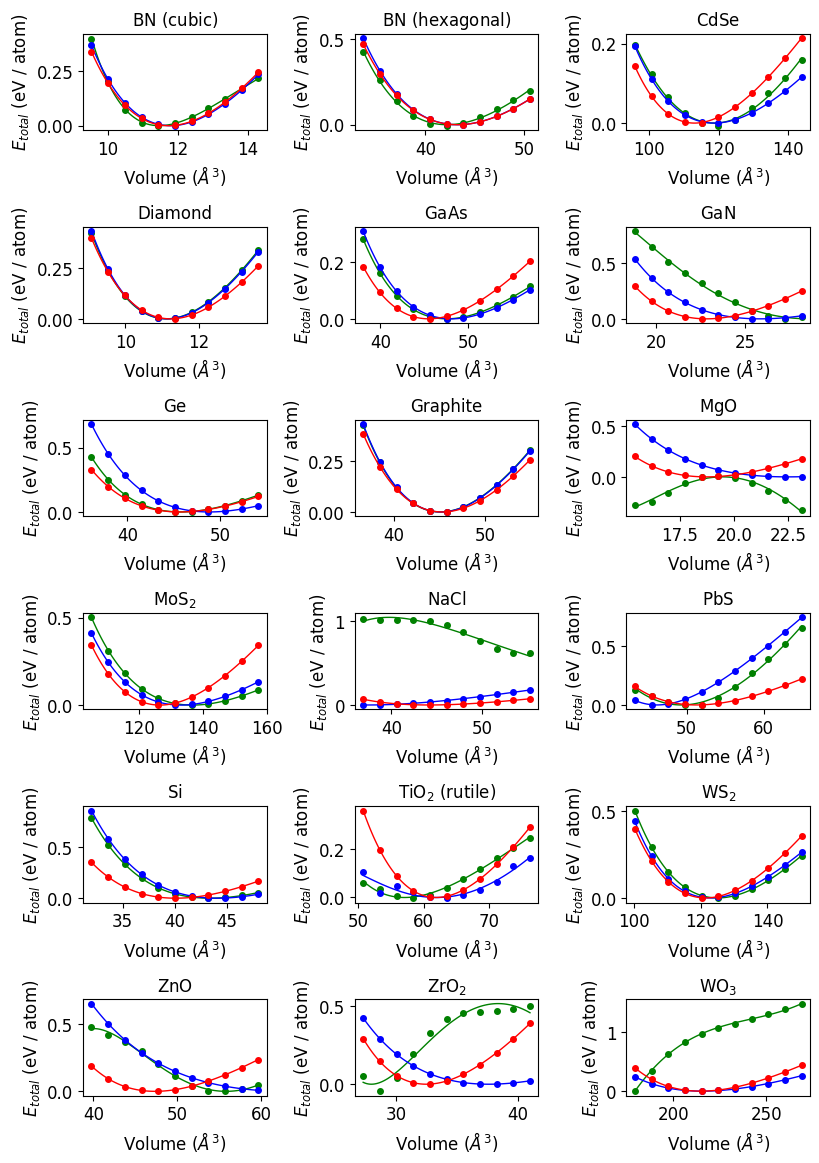

In [16]:
%autoreload
""" Plots. E vs V for TBLite, QCore and QE
"""
from nb_modules.qcore_loaders import load_json_qcore
from nb_modules.nb_plotting import bin_list


print('E vs V: TBLite, QCore and QE')
print('Note: TiO2 Anatase seems to be along way from equilibrum= =>\n'
      'Should replace the CIF reference.')

# Settings
materials = ['bn_cubic', 'bn_hex', 'cdse', 'diamond', 'gaas', 'gan', 'ge', 'graphite', 'mgo', 'mos2',
             'nacl', 'pbs', 'si', 'tio2_rutile', 'ws2', 'zno', 'zro2', 'wo3_monoclinic']

missing_from_qe = ['cu', 'pbte']
ciff_is_bad = ['tio2_ana']

default_optimal_cutoff = {'bn_cubic': '40',
                  'bn_hex': '40',
                  'cdse': '40',
                  'diamond': '40',
                  'gaas': '40',
                  'gan': '40',
                  'germanium': '40',
                  'graphite': '40',
                  'mgo': '40',
                  'mos2': '40',
                  'nacl': '20',
                  'pbs': '40',
                  'silicon': '40',
                  'tio2_rutile': '20',
                  'ws2': '40',
                  'wo3_monoclinic': '40',
                  'zinc_oxide': '40',
                  'zro2': '40'}

# Load data
tb_results = tblite_loader(RESULTS_ROOT, materials)
qe_results = qe_loader(RESULTS_ROOT, materials)
qcore_results = load_json_qcore(RESULTS_ROOT, "qcore/bulk_system_20_and_40_cutoff.json", default_optimal_cutoff, output='np')

tb_results.update({'label': 'TBLite (GFN-xTB 1)', 'color': 'green'})
qe_results.update({'label': 'QE (PBESOL)', 'color': 'red'})
qcore_results.update({'label': 'QCore', 'color': 'blue'})

# Will likely add "full" plot with 3 data sets, to the appendix
plot_type = 'publication'

if plot_type == 'full':
    # Plot with full range of E and V. Good for seeing what's going on
    fig, axes = binned_plot_e_vs_v(materials, [tb_results, qcore_results, qe_results], bin_size = 2)

elif plot_type  == 'publication':
    # Publication quality plot, with tighter limits.
    fig, axs = plot_e_vs_v(materials,
                           [tb_results, qcore_results, qe_results],
                           n_cols=3)   # vol_range = 0.1
    fig.savefig("e_vs_v_bulk_all.eps", dpi=300, bbox_inches="tight")
else:
    pass



## Plots for Main Text Publication

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Setting x range to ± 0.9 V_eq


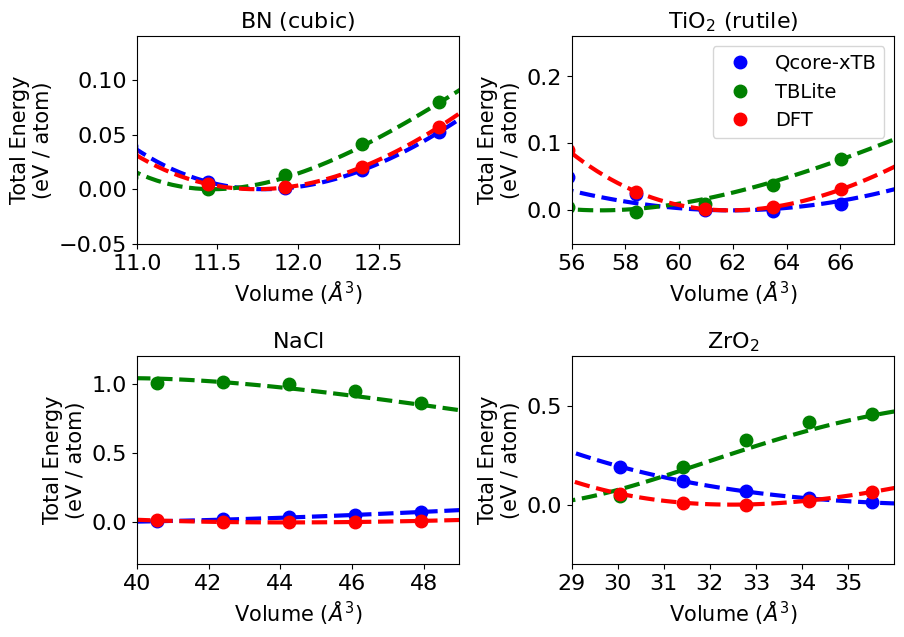

In [17]:
""" Plot showing effect of QCore w.r.t TBLite:

TL. Good improvement, TR. slight regression
BL. Excellent improvement in unphysical behaviour BR. Good improvement in unphysical behaviour
"""
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from delta_factor.loader import qe_loader, tblite_loader
from nb_modules.qcore_loaders import load_json_qcore


default_optimal_cutoff = {'bn_cubic': '40',
                  'bn_hex': '40',
                  'cdse': '40',
                  'diamond': '40',
                  'gaas': '40',
                  'gan': '40',
                  'germanium': '40',
                  'graphite': '40',
                  'mgo': '40',
                  'mos2': '40',
                  'nacl': '20',
                  'pbs': '40',
                  'silicon': '40',
                  'tio2_rutile': '20',
                  'ws2': '40',
                  'wo3_monoclinic': '40',
                  'zinc_oxide': '40',
                  'zro2': '40'}

# Plot settings
n_cols = 2
n_rows = 2

# Calculate the aspect ratio of standard A4
aspect_ratio = 297.0 / 210.0

# Calculate the width of the figure in inches
fig_width = 8.3  # A4 width in inches (approx)

# Calculate the height of the figure in inches to maintain aspect ratio
fig_height = fig_width / aspect_ratio * (n_rows / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
fig.tight_layout(w_pad=5.0, h_pad=6.0)

# ± limits for x-axis. Note, delta factor computed for ±0.06 V_eq
vol_range = 0.1
print(f'Setting x range to ± {1-vol_range} V_eq')

# Point and line sizes
line_width = 3
marker_size = 9

materials = ['bn_cubic', 'tio2_rutile', 'nacl', 'zro2']

qcore_results = load_json_qcore(RESULTS_ROOT, "qcore/bulk_system_20_and_40_cutoff.json", default_optimal_cutoff, output='np')
tblite_results = tblite_loader(RESULTS_ROOT, materials)
qe_results = qe_loader(RESULTS_ROOT, materials)

stepsize = {'bn_cubic': 0.5, 'tio2_rutile': 2, 'zro2': 1, 'nacl': 2}
# meV / atom. Have these manually defined and the others auto-defined
y_range = {'bn_cubic': (-0.05, 0.14), 'tio2_rutile': (-0.05, 0.26), 'zro2': (-0.30, 0.75), 'nacl': (-0.30, 1.2)}

# Plot
cnt = -1
empty_lims = 0, 0

for i, j in itertools.product(range(n_rows), range(n_cols)):
    cnt += 1

    # Exit when last entry is reached.
    if cnt > len(materials) - 1:
        empty_lims = i, j
        break
    material = materials[cnt]

    lite = e_vs_v(tblite_results[material])
    qc = e_vs_v(qcore_results[output_to_internal_label[material]])
    qe = e_vs_v(qe_results[material])

    # Convert to eV per atom
    atoms = bulk_materials[output_to_internal_label[material]]
    prefactor = 1. / float(len(atoms.get_atomic_numbers()))
    qc['model']['energy'] *= prefactor
    qc['data']['energy'] *= prefactor
    qe['model']['energy'] *= prefactor
    qe['data']['energy'] *= prefactor
    lite['model']['energy'] *= prefactor
    lite['data']['energy'] *= prefactor

    axs[i, j].set_xlabel(r"Volume ($\AA^3$)", fontsize=15)
    axs[i, j].set_ylabel("Total Energy\n(eV / atom)", fontsize=15)

    axs[i, j].plot(qc['model']['volume'], qc['model']['energy'], '--', color='b', linewidth=line_width)
    axs[i, j].plot(qc['data']['volume'],  qc['data']['energy'],  'o', color='b', label='Qcore-xTB',  markersize=marker_size)

    axs[i, j].plot(lite['model']['volume'], lite['model']['energy'], '--', color='g', linewidth=line_width)
    axs[i, j].plot(lite['data']['volume'], lite['data']['energy'], 'o', color='g', label='TBLite', markersize=marker_size)

    axs[i, j].plot(qe['model']['volume'], qe['model']['energy'], '--', color='r', linewidth=line_width)
    axs[i, j].plot(qe['data']['volume'],  qe['data']['energy'],  'o', color='r', label='DFT', markersize=marker_size)

    axs[i, j].tick_params(axis='both', which='major', labelsize=16)
    axs[i, j].tick_params(axis='both', which='minor', labelsize=16)

    # Limits consistent with the range over which delta factor was computed
    x_lim, y_lim = set_plot_range(qe['model'], vol_range)
    axs[i, j].set_xlim(x_lim)
    axs[i, j].xaxis.set_ticks(np.arange(x_lim[0], x_lim[1], stepsize[material]))
    # Use limit if defined, else use the auto-limit
    try:
        axs[i, j].set_ylim(y_range[material])
    except KeyError:
        pass

    # Only apply the legend to the 2nd plot
    if cnt == 1: axs[i, j].legend(prop={'size': 14}, loc='upper right')
    axs[i, j].set_title(label_to_title[material], fontsize=16)



plt.savefig("bulk_evsv_comparison.eps", dpi=300,
            bbox_inches='tight', pad_inches=0.1,
            facecolor='auto', edgecolor='auto',
            backend=None, transparent=False)


## Unused Plots

dict_keys(['bn_cubic', 'bn_hex', 'cdse', 'diamond', 'gaas', 'gan', 'graphite', 'mgo', 'mos2', 'nacl', 'pbs', 'tio2_rutile', 'ws2', 'wo3_monoclinic', 'zro2', 'si', 'zno', 'ge'])


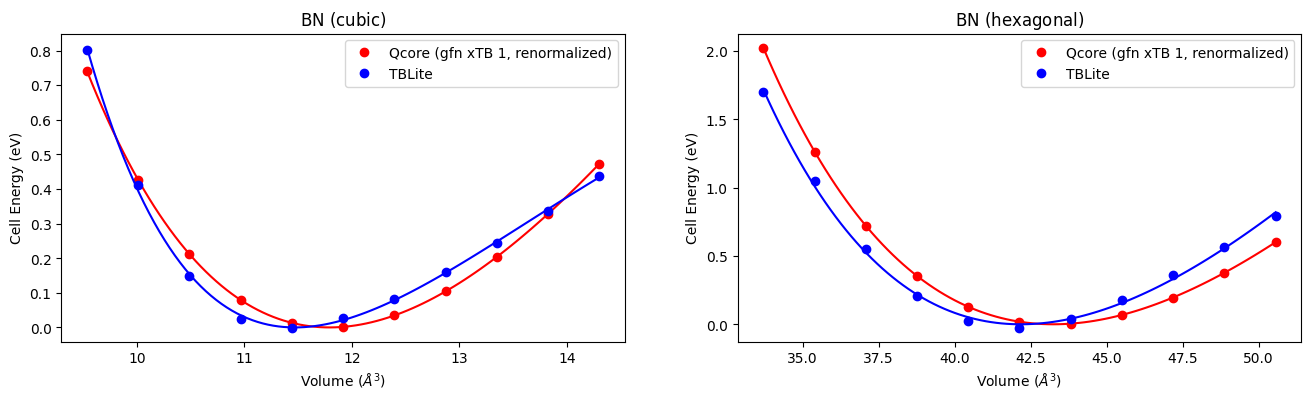

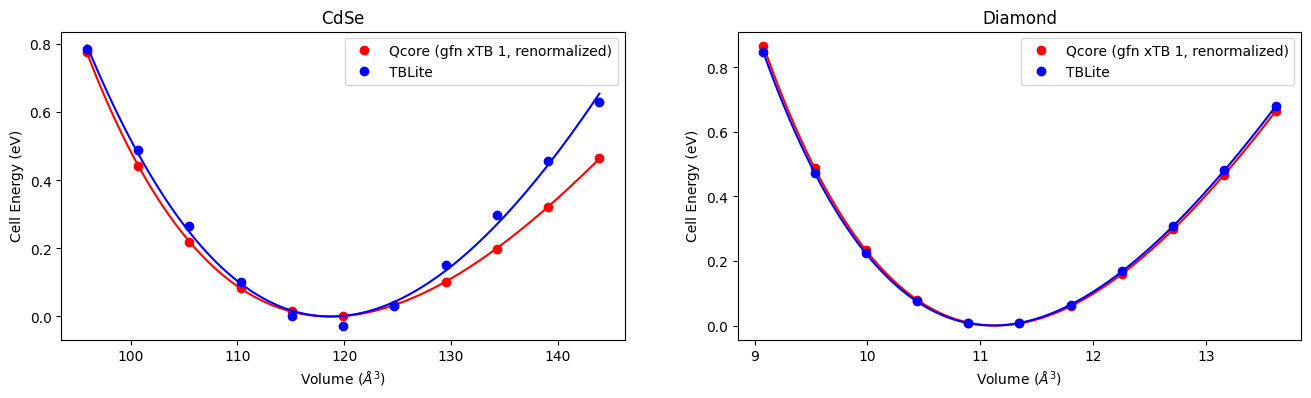

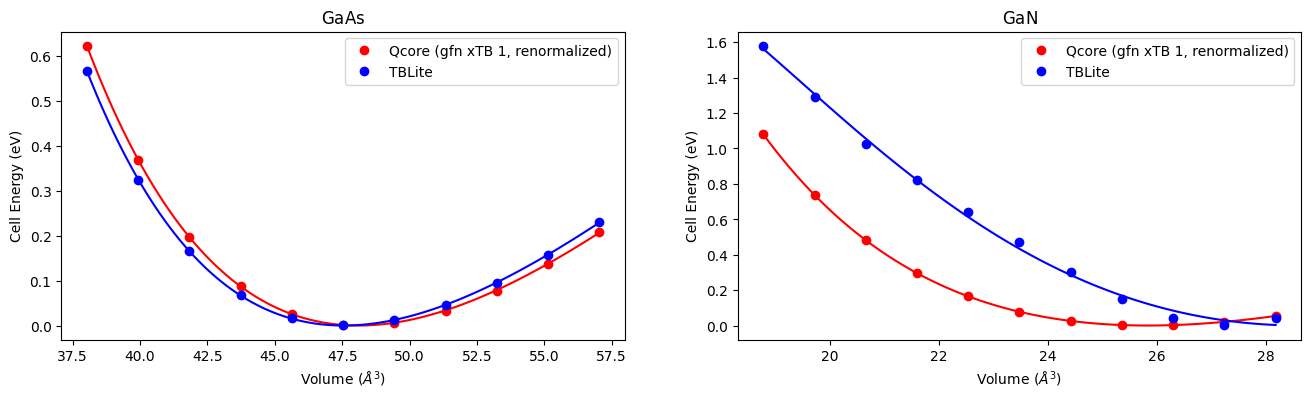

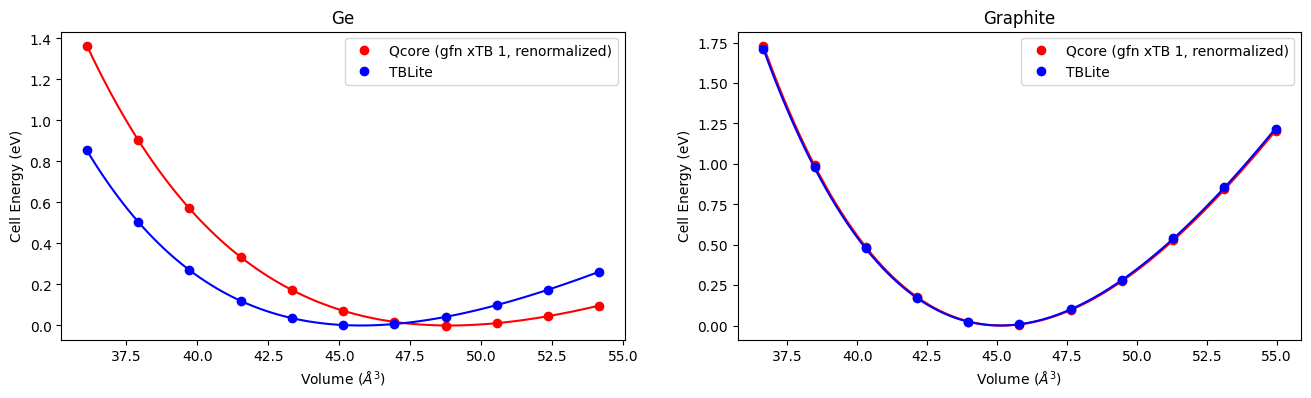

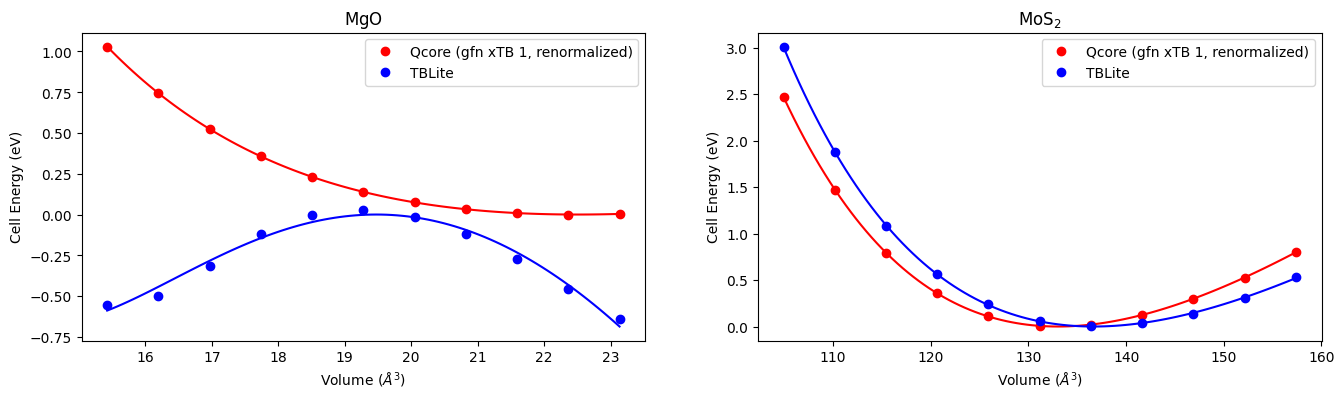

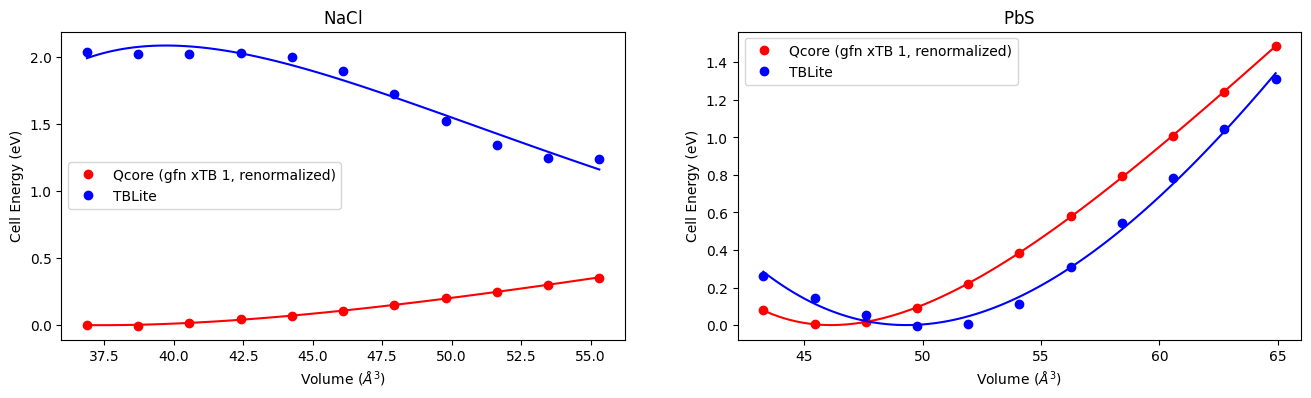

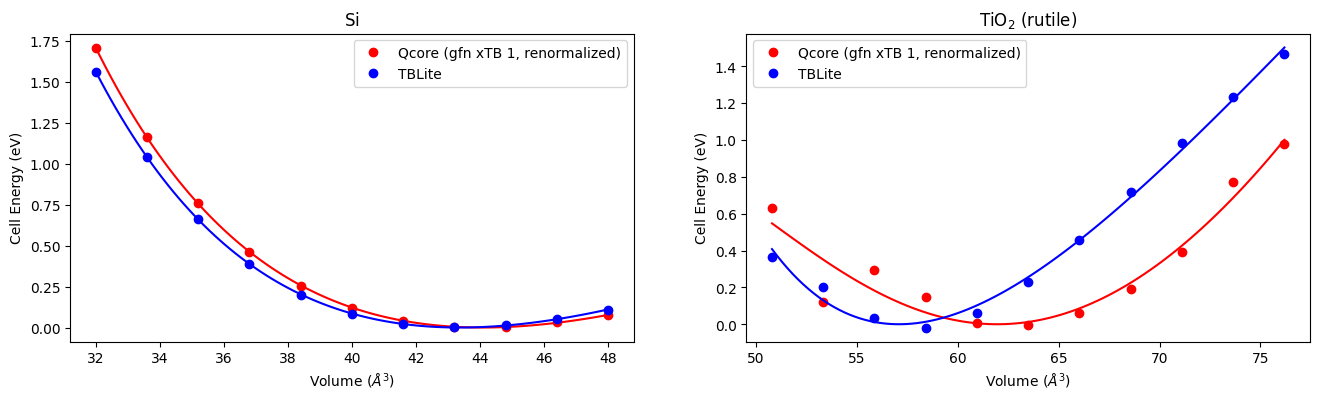

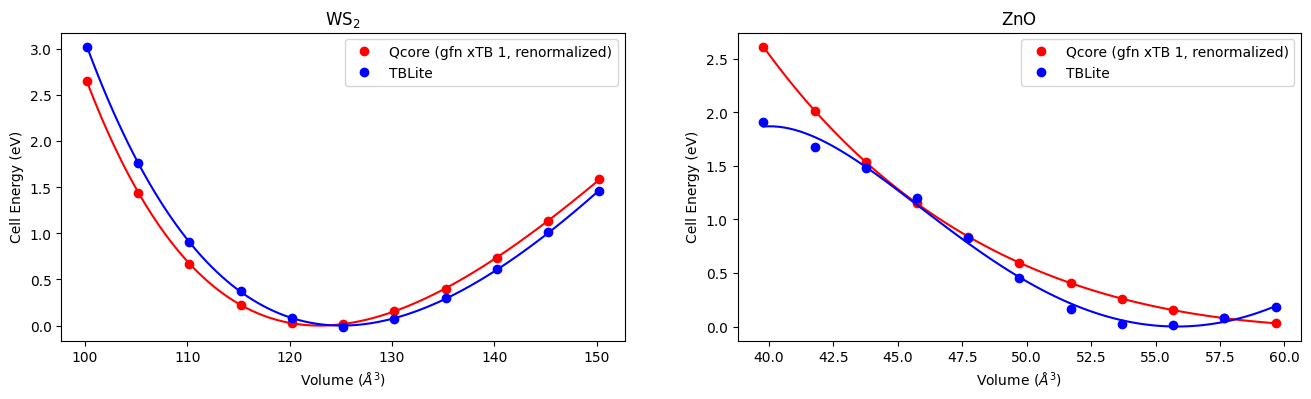

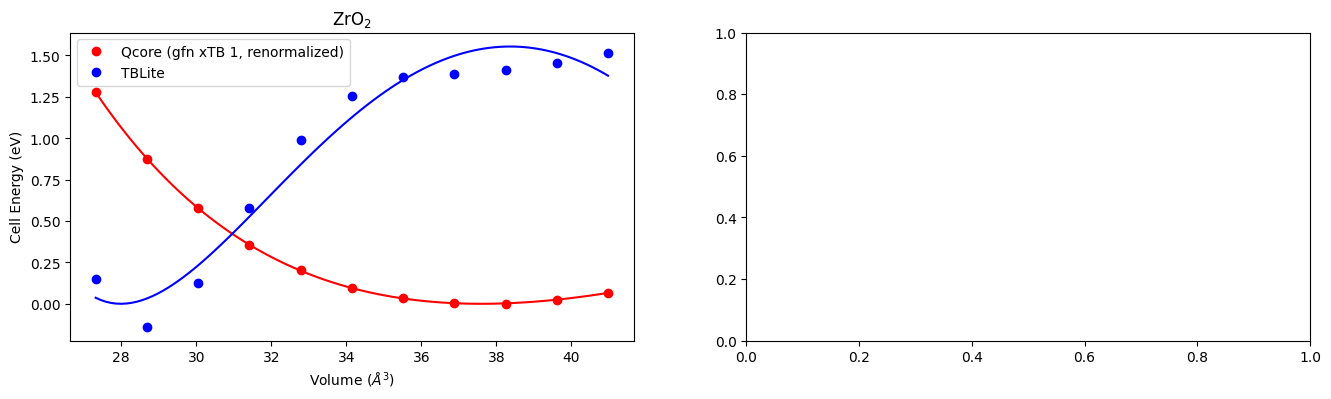

In [22]:
"""E vs V Comparison for Qcore and TBlite
"""
import matplotlib.pyplot as plt

from delta_factor.loader import tblite_loader
from nb_modules.nb_plotting import bin_list
from nb_modules.qcore_loaders import load_json_qcore

#Common materials
materials = ['bn_cubic', 'bn_hex', 'cdse', 'diamond', 'gaas', 'gan', 'ge', 'graphite', 'mgo', 'mos2',
             'nacl', 'pbs', 'si', 'tio2_rutile', 'ws2', 'zno', 'zro2']

missing_from_qe = ['cu', 'pbte', 'wo3_monoclinic']

bin_size = 2
binned_materials = bin_list(materials, bin_size)

qcore_results = load_json_qcore(RESULTS_ROOT, "qcore/bulk_system_20_and_40_cutoff.json", default_optimal_cutoff, output='np')
tb_results = tblite_loader(RESULTS_ROOT, materials)


for bin in binned_materials:
    fig, axs = plt.subplots(1, bin_size, figsize=(16,4))

    for i, material in enumerate(bin):
        qcore = e_vs_v(qcore_results[material])
        tb = e_vs_v(tb_results[material])

        axs[i].set_xlabel(r"Volume ($\AA^3$)")
        axs[i].set_ylabel("Cell Energy (eV)")

        axs[i].plot(qcore['model']['volume'], qcore['model']['energy'], '-', color='r')
        axs[i].plot(qcore['data']['volume'],  qcore['data']['energy'],  'o', color='r', label='Qcore (gfn xTB 1, renormalized)')

        axs[i].plot(tb['model']['volume'], tb['model']['energy'], '-', color='b')
        axs[i].plot(tb['data']['volume'],  tb['data']['energy'],  'o', color='b', label='TBLite')
        axs[i].legend()
        axs[i].set_title(label_to_title[material])

## Notes on Real-space Cutoff

QCore TiO2 rutile and NaCl use 20 Bohr instead of 40 Bohr, however this has a really fractional effect.

* No delta factors change beyond 40 Bohr for QCore.
   * One wonders if this has something to do with the cutoff of interactions used in the original molecular GFN1-xTB parameterisation?
* TiO2 gives a better-looking plot for 40 Bohr, as several points $> V_0$ now fall on the curve.
* NaCl plot looks more or less the same with both cutoffs.
* The quantiative effect on the mean Delta factor across all bulk systems is an improvement of 1.2 when using 20 Bohr for TiO2 rutile and NaCl
   * Negligible effect.
* No testing of convergence with cutoff done with TBlite as this does not appear to be an input variable. 
   * Tests that hack the source suggest this is internally set to 40 - 50 Bohr, however the smoothing function forces the real-space potential to zero at 10 Bohr.

### Effect of Using 40 Bohr

| System       | QCore Equilibrium Volume | Error (%) |
|--------------|---------------------------|-----------|
| NaCl         | 36.20                    | 18.04     |
| TiO₂ (rutile)| 59.37                    | 4.1       |

### Effect of Using 20 Bohr

| System       | QCore Equilibrium Volume | Error (%) |
|--------------|---------------------------|-----------|
| NaCl         | 37.4                     | 15.3      |
| TiO₂ (rutile)| 62.0                     | 0.1       |

### Delta Factor

| System       | 20 B  | 40 B  |
|--------------|-------|-------|
| NaCl         | 36.7  | 52.3  |
| TiO₂ (rutile)| 7.6   | 13.3  |

###  Average Delta Factor for Bulk Systems

| Cutoff (B) | Min   | Mean  | Median | Max  |
|------------|-------|-------|--------|------|
| 40         | 0.32  | 48.7  | 24.4   | 230  |
| 20         | 0.32  | 47.5  | 24.4   | 230  |
